# <span style="color:red"> Main Modelling - Logistic Regression - Gridsearch </span>

* read in pickle v02
* keep 3 translators
* try different feature sets and save model each time
* compare results at the end
* all features available ie normalised counts and pos counts with some drops plus unique words, adj, adv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import label_binarize

import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import class to run modelling steps
from translator_modelling import Modelling

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


Bad key "text.kerning_factor" on line 4 in
/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Load the dataframe containing text chunks and related variables

In [2]:
in_full_path = '../../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [ ]:
df.head(1)

In [ ]:
df.shape

In [ ]:
df.columns

### Check the baseline

In [16]:
baseline_acc = df['trans_code'].value_counts(normalize=True).max()
baseline_acc

0.39927091327705294

## 1. Features = Basic Counts
* choose predictor features
* set predictor and target variables X, y
* perform train/test split
* normalise predictor variables
* gridsearch logistic regression
* score the fitted model
* save fitted model

In [3]:
# prepare modelling
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr = Modelling(df, model)

# select feature groups for modelling
predictor_cols = lr.feature_select()

# drop some individual features eg. those potentially related to page formatting
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lr.drop_features(predictor_cols, cols_to_drop)

# prep data i.e. set X and y, train/test split, normalise predictor variables
X_train, X_test, y_train, y_test, idx_train, idx_test = lr.modelling_prep(predictor_cols, 'trans_code')

# gridsearch model parameters, score fitted model
params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
# lreg_gs_01 = lr.gridsearch(model, params, X_train, y_train)
lr.gridsearch(params, X_train, y_train)

# score the fitted model
lreg_gs_01_results = lr.gridsearch_score(X_train, y_train, X_test, y_test)

# save fitted model
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_01'
out_full_path = out_path + out_name + '.pkl'
lr.save_model(out_full_path)

Best Parameters:
{'C': 100, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.5236221107147895
Best estimator score on the full training set:
0.5257855600863517
Best estimator score on the test set:
0.5426653883029722
ROC-AUC score on the test set:
Class 0: 0.74
Class 1: 0.77
Class 2: 0.61


## 2. Features = Basic Counts + POS Counts

In [4]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr = Modelling(df, model)

predictor_cols = lr.feature_select(basic_counts=True, pos_counts=True)
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lr.drop_features(predictor_cols, cols_to_drop)

X_train, X_test, y_train, y_test, idx_train, idx_test = lr.modelling_prep(predictor_cols, 'trans_code')

params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
lr.gridsearch(params, X_train, y_train)

lreg_gs_02_results = lr.gridsearch_score(X_train, y_train, X_test, y_test)

out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_02'
out_full_path = out_path + out_name + '.pkl'
lr.save_model(out_full_path)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.5905458586312222
Best estimator score on the full training set:
0.5967857999520269
Best estimator score on the test set:
0.6049856184084372
ROC-AUC score on the test set:
Class 0: 0.79
Class 1: 0.81
Class 2: 0.74


## 3. Features = Basic Counts + POS Counts + words

In [6]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr = Modelling(df, model)

predictor_cols = lr.feature_select(basic_counts=True, pos_counts=True, words=True)
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lr.drop_features(predictor_cols, cols_to_drop)

X_train, X_test, y_train, y_test, idx_train, idx_test = lr.modelling_prep(predictor_cols, 'trans_code')

params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
lr.gridsearch(params, X_train, y_train)

lreg_gs_03_results = lr.gridsearch_score(X_train, y_train, X_test, y_test)

out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_03'
out_full_path = out_path + out_name + '.pkl'
lr.save_model(out_full_path)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.652193539286218
Best estimator score on the full training set:
0.6596306068601583
Best estimator score on the test set:
0.6653883029721956
ROC-AUC score on the test set:
Class 0: 0.82
Class 1: 0.84
Class 2: 0.85


## 4. Features = Basic Counts + POS Counts + words + adj

In [11]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr = Modelling(df, model)

predictor_cols = lr.feature_select(basic_counts=True, pos_counts=True, words=True, adj=True)
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lr.drop_features(predictor_cols, cols_to_drop)

X_train, X_test, y_train, y_test, idx_train, idx_test = lr.modelling_prep(predictor_cols, 'trans_code')

params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
lr.gridsearch(params, X_train, y_train)

lreg_gs_04_results = lr.gridsearch_score(X_train, y_train, X_test, y_test)

out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_04'
out_full_path = out_path + out_name + '.pkl'
lr.save_model(out_full_path)

Best Parameters:
{'C': 1, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.6689844283036955
Best estimator score on the full training set:
0.681458383305349
Best estimator score on the test set:
0.6768935762224353
ROC-AUC score on the test set:
Class 0: 0.84
Class 1: 0.84
Class 2: 0.85


## 5. Features = Basic Counts + POS Counts + words + adj + adv

In [8]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr = Modelling(df, model)

predictor_cols = lr.feature_select(basic_counts=True, pos_counts=True, words=True, adj=True, adv=True)
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lr.drop_features(predictor_cols, cols_to_drop)

X_train, X_test, y_train, y_test, idx_train, idx_test = lr.modelling_prep(predictor_cols, 'trans_code')

params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
lr.gridsearch(params, X_train, y_train)

lreg_gs_05_results = lr.gridsearch_score(X_train, y_train, X_test, y_test)

out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_05'
out_full_path = out_path + out_name + '.pkl'
lr.save_model(out_full_path)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.6766617438342244
Best estimator score on the full training set:
0.7004077716478772
Best estimator score on the test set:
0.6951102588686481
ROC-AUC score on the test set:
Class 0: 0.86
Class 1: 0.86
Class 2: 0.86


## 6. Features = Basic Counts + POS Counts + words + adj + adv + vader

In [9]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
lr = Modelling(df, model)

predictor_cols = lr.feature_select(basic_counts=True, pos_counts=True, vader=True, words=True, 
                                   adj=True, adv=True)
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = lr.drop_features(predictor_cols, cols_to_drop)

X_train, X_test, y_train, y_test, idx_train, idx_test = lr.modelling_prep(predictor_cols, 'trans_code')

params = {'C': [0.01, 0.1, 1, 10, 100],
          'penalty': ['l1', 'l2']}
lr.gridsearch(params, X_train, y_train)

lreg_gs_06_results = lr.gridsearch_score(X_train, y_train, X_test, y_test)

out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_gs_06'
out_full_path = out_path + out_name + '.pkl'
lr.save_model(out_full_path)

Best Parameters:
{'C': 1, 'penalty': 'l1'}
Best estimator mean cross validated training score:
0.6828976194794464
Best estimator score on the full training set:
0.708323338930199
Best estimator score on the test set:
0.6883988494726749
ROC-AUC score on the test set:
Class 0: 0.86
Class 1: 0.86
Class 2: 0.86


## Confusion Matrices

In [12]:
lreg_results = [lreg_gs_01_results,
                lreg_gs_02_results,
                lreg_gs_03_results,
                lreg_gs_04_results,
                lreg_gs_05_results,
                lreg_gs_06_results]

In [13]:
for i, results in enumerate(lreg_results):
    print('model:', i+1)
    print(pd.DataFrame(results['conmat'], index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))
    print('\n')

model: 1
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 221              108                 16
actual rubin                     86              322                  8
actual gabriel                  126              133                 23


model: 2
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 222               82                 41
actual rubin                     77              310                 29
actual gabriel                   83              100                 99


model: 3
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 229               81                 35
actual rubin                     72              304                 40
actual gabriel                   61               60                161


model: 4
                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum       

## Confusion Matrix Comments
* Model 1 - basic counts: does very well for Birnbaum and Rubin but very badly for Gabriel
* Model 2 - basic + POS counts: slight improvement for Birnbaum, a slight drop for Rubin. Gabriel is much improved but still the lowest accuracy
* Model 3 - basic + POS + word counts: Gabriel accuracy imrpoves significantly
* Model 4 - basic + POS + word counts + adj: no significant improvement on the test scores
* Model 5 - basic + POS + word counts + adj + adv: slight improvement across the board
* Model 6 - basic + POS + word counts + adj + adv + vader: no significant improvement on the test scores

## Classification Report
!!! to be set up!!!

In [ ]:
# predictions = lreg_gs_01.predict(X_test)
# print(classification_report(y_test, predictions))

In [14]:
model_nums = []
cv_scores = []
train_scores = []
test_scores = []
auc_0 = []
auc_1 = []
auc_2 = []


for i, results in enumerate(lreg_results):
    model_nums.append(i+1)
    cv_scores.append(results['Best_CV_Score'])
    train_scores.append(results['Best_Train_Score'])
    test_scores.append(results['Best_Test_Score'])
    auc_0.append(results['AUC_Class_0'])
    auc_1.append(results['AUC_Class_1'])
    auc_2.append(results['AUC_Class_2'])

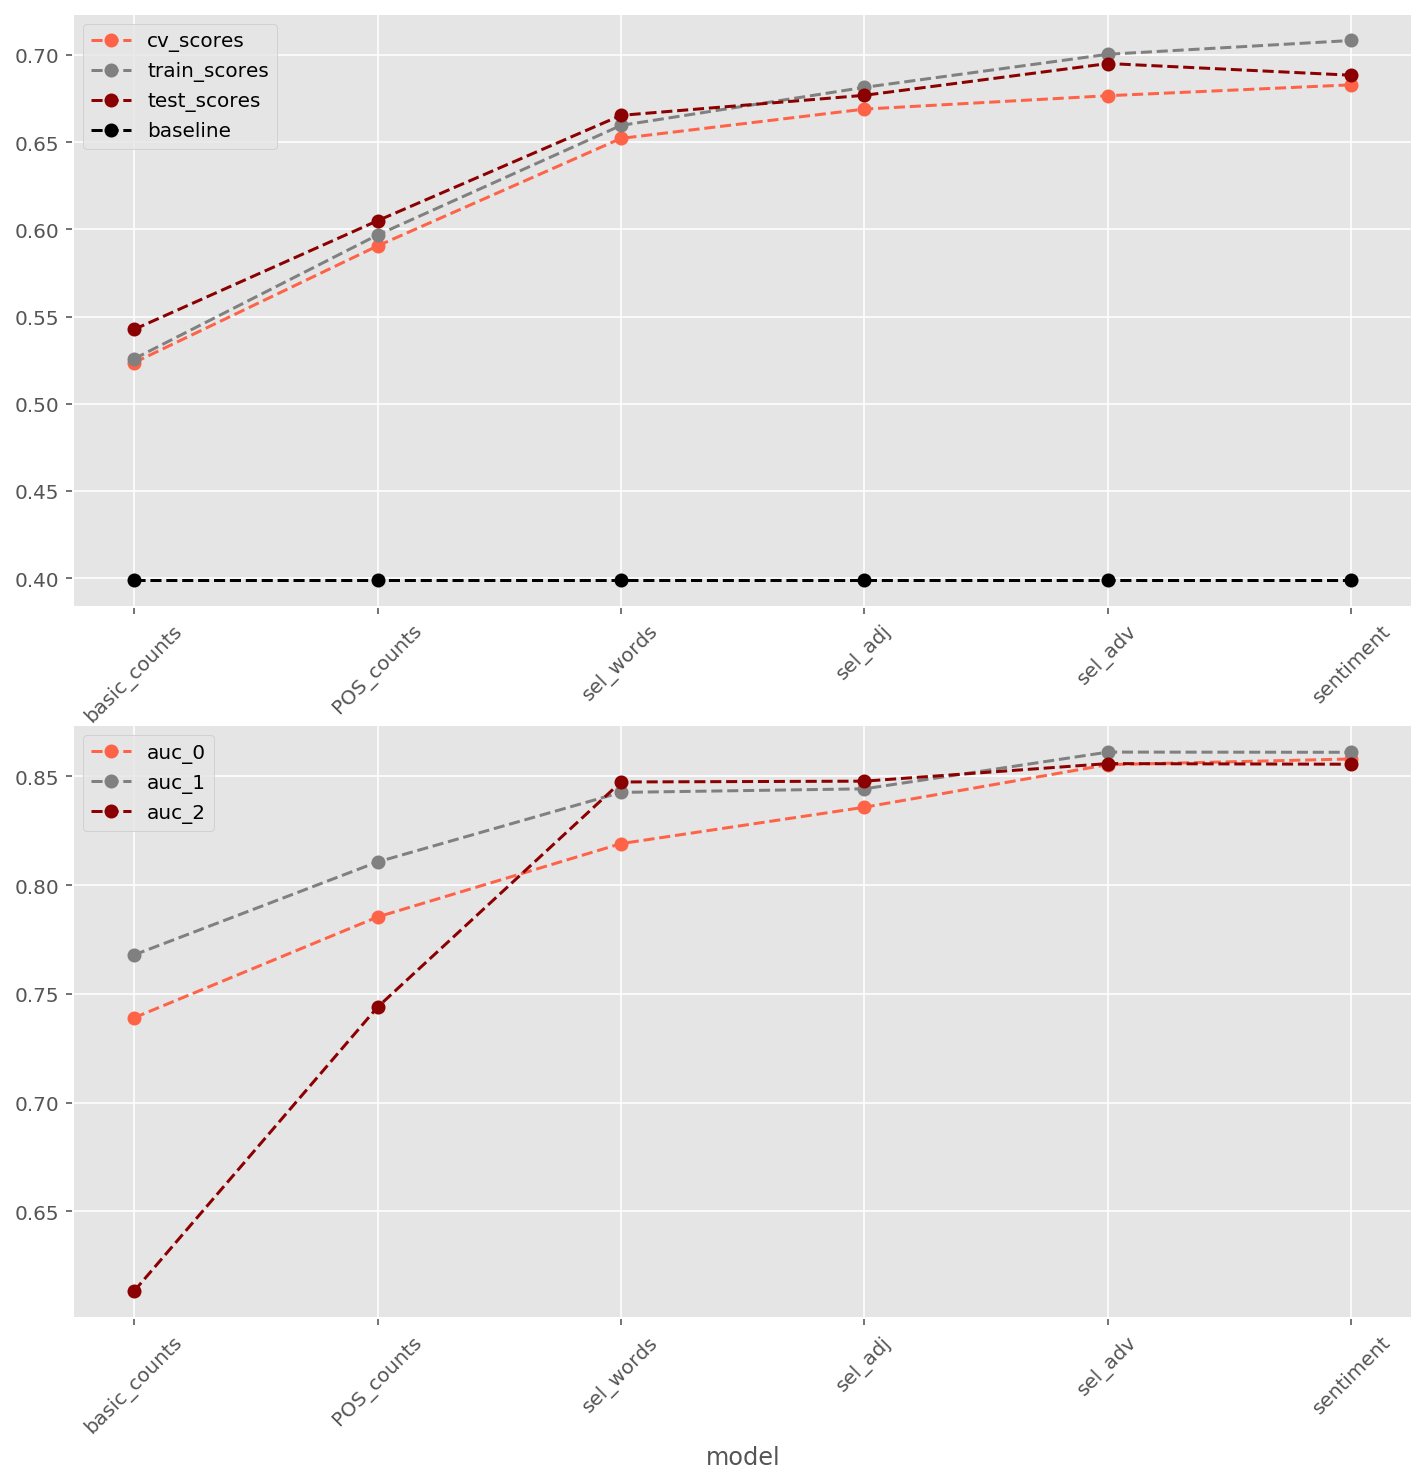

In [17]:
sns.set_palette(['tomato', 'gray', 'darkred', 'black'])
dict_cv_scores = {'model': model_nums, 
                  'cv_scores': cv_scores, 
                  'train_scores': train_scores,
                  'test_scores': test_scores,
                  'auc_0': auc_0,
                  'auc_1': auc_1,
                  'auc_2': auc_2,}
df_cv_scores = pd.DataFrame(dict_cv_scores)
df_cv_scores['baseline'] = baseline_acc

fig, ax = plt.subplots(nrows=2, figsize=(12,12))


df_cv_scores.sort_values(by='model').plot(x='model', y='cv_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='train_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='test_scores', linestyle='--', marker='o', ax=ax[0])
df_cv_scores.sort_values(by='model').plot(x='model', y='baseline', linestyle='--', marker='o', ax=ax[0])

df_cv_scores.sort_values(by='model').plot(x='model', y='auc_0', linestyle='--', marker='o', ax=ax[1])
df_cv_scores.sort_values(by='model').plot(x='model', y='auc_1', linestyle='--', marker='o', ax=ax[1])
df_cv_scores.sort_values(by='model').plot(x='model', y='auc_2', linestyle='--', marker='o', ax=ax[1])

labels = ['', 'basic_counts', 'POS_counts', 'sel_words', 'sel_adj', 'sel_adv', 'sentiment']
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels[1] = 'Testing'

ax[0].set_xticklabels(labels)
ax[0].tick_params(axis='x', labelrotation=45)
ax[1].set_xticklabels(labels)
ax[1].tick_params(axis='x', labelrotation=45)




plt.savefig('../../../../Documents/murakami/plots/lreg_sel_feature_scores.png')
plt.show()

## Run a best logistic regression

In [18]:
lreg_gs_06.best_params_

NameError: name 'lreg_gs_06' is not defined

In [19]:
predictor_cols = lr.feature_select(basic_counts=True, pos_counts=True, vader=False, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

indices = list(df.index)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_final = LogisticRegression(C=1, penalty='l1', solver='liblinear', multi_class='ovr', max_iter=1000)

lreg_final.fit(X_train, y_train)
predictions = lreg_final.predict(X_test)
lreg_final.score(X_test, y_test)

0.6951102588686481

In [ ]:
# set the output path and name
out_path = '../../../../Documents/murakami/pkl_models/'
out_name = 'lreg_final'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(lreg_final, fp)

## Precision-Recall Plot

In [ ]:
probabilities = lreg_final.predict_proba(X_test)

In [ ]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

In [ ]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

In [ ]:
# label binarizer - not sure if needed?
y_bin = label_binarize(y_test, lreg_final.classes_)

In [ ]:
print('Area under precision-recall curve:')
for i, class_ in enumerate(lreg_final.classes_):
    print('Class {}:'.format(class_), round(average_precision_score(y_bin[:,i],lreg_final.predict_proba(X_test)[:,i]),4))

## ROC Plot

In [ ]:
skplt.metrics.plot_roc(y_test, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,8), cmap=cmap)
plt.show()

In [ ]:
print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(lreg_final.classes_):
    print('Class {}:'.format(class_), round(roc_auc_score(y_bin[:,i],lreg_final.predict_proba(X_test)[:,i]),2))

In [ ]:
# skplt.metrics.roc_curve(y_test==0, probabilities[:,0])

In [ ]:
# code could be useful for refactoring some of the code above - extracting from tuples/dicts etc to df
# df_pred = pd.DataFrame([(x.r_ui, x.est) for x in predictions_full],
#                        columns=['Rating', 'Predicted'])